# Initialization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import pickle
import os
import time
import subprocess
import json
from tensorflow.keras import models, optimizers, callbacks
from tensorflow.keras.layers import Dense, BatchNormalization
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# making plots beautiful:
SMALL_SIZE = 20//1.4
MEDIUM_SIZE = 24//1.4
BIGGER_SIZE = 28//1.4
plt.rc('font', size=SMALL_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)    
plt.rc('axes', labelsize=MEDIUM_SIZE)   
plt.rc('xtick', labelsize=SMALL_SIZE)   
plt.rc('ytick', labelsize=SMALL_SIZE)   
plt.rc('legend', fontsize=SMALL_SIZE)   
plt.rc('figure', titlesize=BIGGER_SIZE)

# Data generation runtime

C:\ProgramData\Anaconda3\envs\MeshGraphNet\lib\site-packages\ipykernel_launcher.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator


<Figure size 432x288 with 0 Axes>

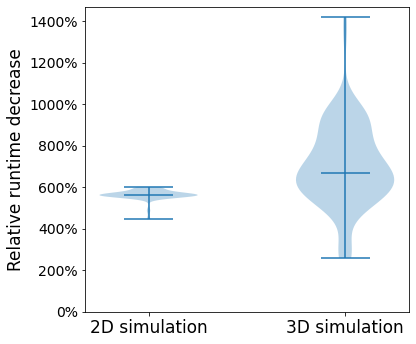

In [2]:
# Before running the follwing code, make sure to first generate all the datasets
# by numerical models. Here, the datasets are gathered to show the runtimes.

time_lf_1 = np.loadtxt(os.path.join('gnn_datasets', 'Model-1', 'time_lf.csv'), delimiter=",", dtype='float32')
time_hf_1 = np.loadtxt(os.path.join('gnn_datasets', 'Model-1', 'time_hf.csv'), delimiter=",", dtype='float32')
time_lf_2 = np.loadtxt(os.path.join('gnn_datasets', 'Model-2', 'time_lf.csv'), delimiter=",", dtype='float32')
time_hf_2 = np.loadtxt(os.path.join('gnn_datasets', 'Model-2', 'time_hf.csv'), delimiter=",", dtype='float32')
time_lf_2d = np.concatenate((time_lf_1, time_lf_2))
time_hf_2d = np.concatenate((time_hf_1, time_hf_2))
time_2d = (time_hf_2d - time_lf_2d) / time_lf_2d

time_hf_3d = np.loadtxt('time_input_3d.csv', delimiter=",", dtype='float32')
time_lf_3d = np.loadtxt('time_output_3d_lowfidelity.csv', delimiter=",", dtype='float32')
time_3d = (time_hf_3d - time_lf_3d) / time_lf_3d

plt.clf()

data = [time_2d, time_3d]

plt.figure(figsize=(6, 5))

labels = ['2D simulation', '3D simulation']

plt.violinplot(data, showmeans=False, showmedians=True)
plt.xticks(np.arange(1, len(labels)+1), labels, fontsize=MEDIUM_SIZE)

plt.ylim(0, np.max(np.concatenate(data, axis = -1))+0.5)
plt.ylabel('Relative runtime decrease')

plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.tight_layout()
plt.savefig('comparison.pdf', format='pdf', dpi=500)

In [3]:
# Now, we show them in two tables:

def sec_fn(x):
    '''A helper funtion to show the seconds.'''
    if x >= 60:
        minute = int(x // 60)
        return str(int(x - minute*60))
    else:
        return str(int(x))

def min_fn(x):
    '''A helper funtion to show the minutes.'''
    if x >= 60:
       minute = int(x // 60)
       return str(minute)
    else:
      return str('0')

# Vectorization is used to apply all funtions on each element:
min_fn = np.vectorize(min_fn)
sec_fn = np.vectorize(sec_fn)

# For concatenation, we need to reshape them:
min_hf_2d = min_fn(time_hf_2d.T).reshape((time_hf_2d.shape[0],1))
min_lf_2d = min_fn(time_lf_2d.T).reshape((time_lf_2d.shape[0],1))
sec_hf_2d = sec_fn(time_hf_2d.T).reshape((time_hf_2d.shape[0],1))
sec_lf_2d = sec_fn(time_lf_2d.T).reshape((time_lf_2d.shape[0],1))
data = np.concatenate([min_lf_2d, sec_lf_2d, min_hf_2d, sec_hf_2d], axis = -1)

multi_index = pd.MultiIndex.from_tuples([("LF", "Min"),
                                      ("LF", "Sec"),
                                      ("HF", "Min"),
                                      ("HF", "Sec"),],
                                      names=['Model type','Runtime'])

index_2d = ['2D sample '+str(i) for i in range(1,len(time_hf_2d)+1)]
df_2d = pd.DataFrame(data, index = index_2d, columns = multi_index)


# And likewise for the 3d model:
min_hf_3d = min_fn(time_hf_3d.T).reshape((time_hf_3d.shape[0],1))
min_lf_3d = min_fn(time_lf_3d.T).reshape((time_lf_3d.shape[0],1))
sec_hf_3d = sec_fn(time_hf_3d.T).reshape((time_hf_3d.shape[0],1))
sec_lf_3d = sec_fn(time_lf_3d.T).reshape((time_lf_3d.shape[0],1))
data = np.concatenate([min_lf_3d, sec_lf_3d, min_hf_3d, sec_hf_3d], axis = -1)

index_3d = ['3D sample '+str(i) for i in range(1,len(time_hf_3d)+1)]
df_3d = pd.DataFrame(data, index = index_3d, columns = multi_index)

print(pd.concat([df_2d, df_3d]).to_latex())

\begin{tabular}{lllll}
\toprule
Model type & \multicolumn{2}{l}{LF} & \multicolumn{2}{l}{HF} \\
Runtime & Min & Sec & Min & Sec \\
\midrule
2D sample 1   &   0 &  21 &   2 &  21 \\
2D sample 2   &   0 &  21 &   2 &  21 \\
2D sample 3   &   0 &  21 &   2 &  21 \\
2D sample 4   &   0 &  21 &   2 &  21 \\
2D sample 5   &   0 &  21 &   2 &  21 \\
2D sample 6   &   0 &  21 &   2 &  21 \\
2D sample 7   &   0 &  21 &   2 &  20 \\
2D sample 8   &   0 &  21 &   2 &  19 \\
2D sample 9   &   0 &  21 &   2 &  22 \\
2D sample 10  &   0 &  21 &   2 &  21 \\
2D sample 11  &   0 &  21 &   2 &  21 \\
2D sample 12  &   0 &  21 &   2 &  21 \\
2D sample 13  &   0 &  21 &   2 &  21 \\
2D sample 14  &   0 &  21 &   2 &  21 \\
2D sample 15  &   0 &  21 &   2 &  21 \\
2D sample 16  &   0 &  21 &   2 &  21 \\
2D sample 17  &   0 &  21 &   2 &  21 \\
2D sample 18  &   0 &  21 &   2 &  22 \\
2D sample 19  &   0 &  21 &   2 &  21 \\
2D sample 20  &   0 &  21 &   2 &  22 \\
2D sample 21  &   0 &  21 &   2 &  21 \\

# 2D Simulation

In [4]:
# Alls the datasets are continuously converted to tfrecords for
# the graph models as the original MeshGraphNets code requires.

BytesList = tf.train.BytesList
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

class db_convertor():
    '''THis class is used to first set aside a valid or test set, then from the
    remainings, each time different groups of training sets are saved for training
    with different numbers of samples by save_tfrecords.'''
    def __init__(self, ModelName):
        
        self.dir_address = os.path.join("gnn_datasets", self.ModelName)
        os.chdir(self.dir_address)

        # Meta files contain important information to properly import serialized CSV files.
        with open("meta.json", "r") as f: meta = json.load(f)
        
        features = {}
        for field_name in meta["field_names"]:
            dtype = meta["features"][field_name]["dtype"]
            features[field_name] = np.loadtxt(field_name + ".csv", delimiter = ",", dtype=dtype)
            
            # It is important to correct the types of the files to prevent errors in the graph model.
            if dtype=='float64':
                features[field_name] = features[field_name].astype('float32')
                meta["features"][field_name]["dtype"] = 'float32'
            
            # As Abaqus cell's indecies starts from 1 instead of 0:
            if field_name == "cells": features[field_name] -= 1
            
            # Reshaping again back to what it used to be:
            features[field_name] = features[field_name].reshape(meta["total_num_samples"], -1)
    
        np.random.seed(40)
        np.random.shuffle(features[field_name])
        
        self.features = features
        
        with open("meta.json", "w") as f: json.dump(meta, f, indent=2, separators=(", ", ": "))

        self.meta = meta

        os.chdir("..\..")

    def save_tfrecords(self, key, sliceList = None, resetAddress = True):
        
        os.chdir(self.dir_address)
        if sliceList == None: sliceList = [0, self.meta["total_num_samples"]]
        
        features = self.features
        meta = self.meta
    
        with tf.io.TFRecordWriter(key+".tfrecord") as f:
            for array_slice_key in range(sliceList[0],sliceList[1]):
                temp = {feature_key: Feature(bytes_list=BytesList(
                            value=[features[feature_key][array_slice_key].tobytes()]))
                            for feature_key in meta["field_names"]}
                person_example = Example(features=Features(feature=temp))
                
                f.write(person_example.SerializeToString())
        
        os.chdir("..\..")

In [5]:
def perform_2d_experiment(experiment_id, latent_size, num_layers, message_passing_steps, n_initial_steps,
                          num_training_steps, learning_rate, only_evaluate=False):
    '''This function performs training and evaluation for all surrogate models
    but only using a single and common training and evaluation sets.'''

    def run_2d(db_key, name, checkpoint_folder, dataset_folder, input_hf, input_nodal_disp,
             input_fixed_nodes, input_mat, n_initial_steps=None, num_training_steps=None):
        '''This function calls and runs gnn.py, containing the graph-based model.'''

        cmd = ["conda", "activate", "meshgraphnet", "&&", "python", "gnn.py", str(latent_size), str(num_layers),
               str(message_passing_steps), db_key, name, checkpoint_folder+"_"+experiment_id, dataset_folder, 
               str(input_hf), str(input_nodal_disp), str(input_fixed_nodes), str(input_mat)]
        
        if n_initial_steps != None:
            if num_training_steps == None:
                raise Exception("Error: define both num_training_steps and n_initial_steps together")
          
            cmd.extend([str(n_initial_steps), str(num_training_steps), str(learning_rate)])
        
        print(subprocess.getoutput(cmd))
    
    # These lists are gradually filled by different values passed into gnn.py. 
    db_key_list=[]              
    name_list=[]              
    checkpoint_folder_list=[] 
    dataset_folder_list=[]    
    input_hf_list=[]
    input_nodal_disp_list=[]
    input_fixed_nodes_list=[]
    input_mat_list=[]
    n_initial_steps_list=[]   
    num_training_steps_list=[]
    
    def append_list(db_key, name, checkpoint_folder, dataset_folder, input_hf, input_nodal_disp,
                    input_fixed_nodes, input_mat, n_initial_steps=None, num_training_steps=None):
        '''A helper function to append elements of the above lists'''
        db_key_list.append(db_key)              
        name_list.append(name)              
        checkpoint_folder_list.append(checkpoint_folder) 
        dataset_folder_list.append(dataset_folder)    
        input_hf_list.append(input_hf)
        input_nodal_disp_list.append(input_nodal_disp)    
        input_fixed_nodes_list.append(input_fixed_nodes)            
        input_mat_list.append(input_mat)         
        n_initial_steps_list.append(n_initial_steps)   
        num_training_steps_list.append(num_training_steps)
    
    # Append values for training of the ML model
    append_list(db_key="train",
                name="ml",
                checkpoint_folder="ML model",
                dataset_folder="model-1",
                input_hf=False,
                input_nodal_disp=True,
                input_fixed_nodes=True,
                input_mat=True,
                n_initial_steps=n_initial_steps,
                num_training_steps=num_training_steps)
    
    # Append values for training of the HML model
    append_list(db_key="train",
                name="hml",
                checkpoint_folder="HML model",
                dataset_folder="model-1",
                input_hf=False,
                input_nodal_disp=False,
                input_fixed_nodes=False,
                input_mat=False,
                n_initial_steps=n_initial_steps,
                num_training_steps=num_training_steps)
    
    # Append values for training of the HML model with HF inputs
    append_list(db_key="train",
                name="hml",
                checkpoint_folder="HML model (with HF inputs)",
                dataset_folder="model-1",
                input_hf=True,
                input_nodal_disp=False,
                input_fixed_nodes=False,
                input_mat=False,
                n_initial_steps=n_initial_steps,
                num_training_steps=num_training_steps)
    
    # Now for evaluation's list items, we copy the above updated lists first by below lists
    # used to iterate on the currect values. Next, passed values for evaluation parameters
    # are defined and appended to the list. 
    name_list_temp = name_list[:]
    checkpoint_folder_list_temp = checkpoint_folder_list[:]
    input_hf_list_temp = input_hf_list[:]
    input_nodal_disp_list_temp = input_nodal_disp_list[:]
    input_fixed_nodes_list_temp = input_fixed_nodes_list[:]
    input_mat_list_temp = input_mat_list[:]
    
    for db_key, dataset_folder in zip(["train", "valid", "test"], ["model-1", "model-1", "model-2"]):
        for (name, checkpoint_folder, input_hf, input_nodal_disp, input_fixed_nodes,
             input_mat) in zip(name_list_temp, checkpoint_folder_list_temp, input_hf_list_temp,
             input_nodal_disp_list_temp, input_fixed_nodes_list_temp, input_mat_list_temp):
          
            append_list(db_key=db_key,
                        name=name,
                        checkpoint_folder=checkpoint_folder,
                        dataset_folder=dataset_folder,
                        input_hf=input_hf,
                        input_nodal_disp=input_nodal_disp,
                        input_fixed_nodes=input_fixed_nodes,
                        input_mat=input_mat)
    
    # Now, we run the loop once for each group of passed values.
    for (db_key, name, checkpoint_folder, dataset_folder, input_hf, input_nodal_disp,
         input_fixed_nodes, input_mat, n_initial_steps, num_training_steps) in zip(db_key_list,
         name_list, checkpoint_folder_list, dataset_folder_list, input_hf_list, input_nodal_disp_list, 
         input_fixed_nodes_list, input_mat_list, n_initial_steps_list, num_training_steps_list):
        
        # If you prefer to only evaluate currently trained models use this condition.
        if (n_initial_steps!=None and only_evaluate==True): continue
        
        run_2d(db_key, name, checkpoint_folder, dataset_folder, input_hf, input_nodal_disp,
               input_fixed_nodes, input_mat, n_initial_steps, num_training_steps)
    
    return checkpoint_folder_list, n_initial_steps_list

In [6]:
def run_2d_experiments_on_samples(data_name = "data_2d",
                                  sampleList = [4,9,14,20],
                                  latent_size=40,
                                  num_layers=3,
                                  message_passing_steps=3,
                                  n_initial_steps=400,
                                  num_training_steps=10000,
                                  learning_rate=1e-4,
                                  only_evaluate=False):
    '''This function first defines different numbers of samples and save
    training datasets. Next, it runs the training or evaulation for them
    using the perform_2d_experiment function. The returned values are saved
    in a dictionary for later use.'''

    data = {}
    model_1_db = db_convertor("model-1")
    model_1_db.save_tfrecords("valid", [20,30])
    model_2_db = db_convertor("model-2")
    model_2_db.save_tfrecords("test", [0,10])
    for n_samples in sampleList:
        experiment_id = "%s_%s"%(n_samples, num_training_steps)
        data[experiment_id] = {}
        model_1_db.save_tfrecords("train", [0, n_samples])
        
        a, b = perform_2d_experiment(experiment_id, latent_size=latent_size, num_layers=num_layers,
                                     message_passing_steps=message_passing_steps, n_initial_steps=n_initial_steps,
                                     num_training_steps=num_training_steps, only_evaluate=only_evaluate,
                                     learning_rate=learning_rate)
        
        checkpoint_folder_list = [checkpoint_folder+"_"+experiment_id for checkpoint_folder in a]
        data[experiment_id]["checkpoint_folder_list"] = checkpoint_folder_list
        data[experiment_id]["n_initial_steps_list"] = b
    
    with open(data_name, 'wb') as f: pickle.dump(data, f)

In [22]:
# 2D model 1:

run_2d_experiments_on_samples(data_name = "data_2d_1",
                              n_initial_steps=100,
                              num_training_steps=1000,
                              learning_rate=1e-3)

2022-04-09 13:05:52.273675: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2022-04-09 13:05:52.273865: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
2022-04-09 13:05:59.613882: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not

In [11]:
# 2D model 2:

run_2d_experiments_on_samples(data_name = "data_2d_2",
                              n_initial_steps=100,
                              num_training_steps=8000,
                              message_passing_steps=6)

2022-04-09 08:18:28.133111: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_100.dll'; dlerror: cudart64_100.dll not found
2022-04-09 08:18:28.133298: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
2022-04-09 08:18:40.565385: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not

In [13]:
# Loading and combining the evaluations' errors for each 2D surrogate and saving
# them into a new dictionary that is simpler for the subsequent data visualization.
data_name_list = ["data_2d_1", "data_2d_2"]

table = {}
for data_name in data_name_list:
    table[data_name] = {}
    with open(data_name, 'rb') as f: data = pickle.load(f)
    
    for experiment_id in data.keys():
        checkpoint_folder_list = data[experiment_id]["checkpoint_folder_list"]
        n_initial_steps_list = data[experiment_id]["n_initial_steps_list"]
        n_samples = experiment_id.split("_")[0]
        table[data_name][n_samples] = {}
        for checkpoint_folder in checkpoint_folder_list:
            model_type = checkpoint_folder.split("_")[0]
            table[data_name][n_samples][model_type] = {}
            
            for db_key in ["valid", "test"]:
                fdir=os.path.join("dir", checkpoint_folder, 'evaluation_(%s).npy'%(db_key))
                with open(fdir, 'rb') as f:
                    errorList = np.load(f)
                    targetList = np.load(f)
                    predictionList = np.load(f)
                
                mse = (np.square(targetList[:,0,:,:] - predictionList[:,:,:])).mean()
                table[data_name][n_samples][model_type][db_key] = [mse] # this clarifies its structure

<Figure size 432x288 with 0 Axes>

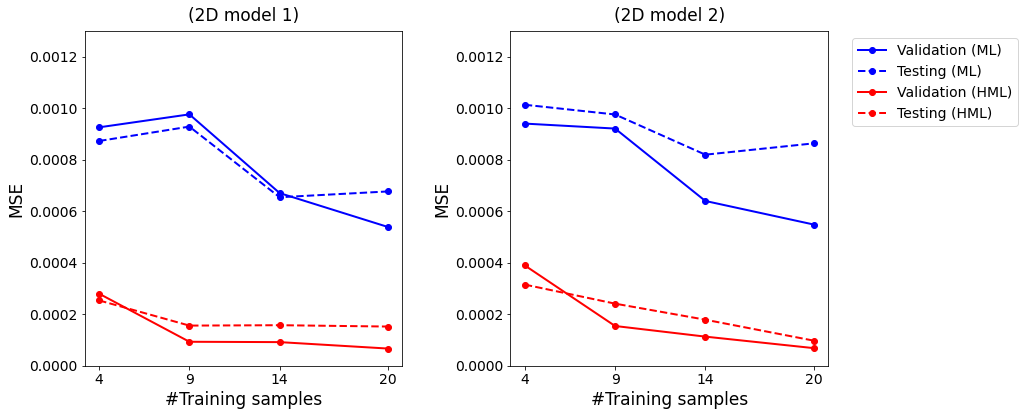

In [14]:
plt.clf();
fig = plt.figure(figsize=(15, 6))

i = 0
ax = []

x = n_samples_list = [int(key) for key in table[data_name].keys()]
model_list = list(table[data_name][n_samples])

for data_name in data_name_list:
    i += 1
    ax.append(fig.add_subplot(1, 2, i))
    for model in model_list[:2]:
        if model == 'ML model':
            style_type = 'bo'
        elif model == 'HML model':
            style_type = 'ro'
        else:
            style_type = 'yo'
        
        for db_type in ['valid', 'test']:
            if db_type == 'valid':
                style = '-' + style_type
            else:
                style = '--' + style_type
        
            y = []
            for n_sample in n_samples_list:
                y.append(table[data_name][str(n_sample)][model][db_type])
            
            linewidth = 2
            ax[-1].plot(x, y, style, linewidth=linewidth)
            ax[-1].set(xlabel='#Training samples', ylabel='MSE')
    
    ax[-1].set_xticks(x)
    ax[-1].set_ylim(0,13e-4)
    ax[-1].ticklabel_format(useOffset=False)
    ax[-1].set_title('(2D model %s)'%(i), pad=10)

ax[-1].legend(['Validation (ML)', 'Testing (ML)', 'Validation (HML)', 'Testing (HML)'], bbox_to_anchor= (1.62,1))

fig.tight_layout()
fig.subplots_adjust(wspace=0.34 , hspace=0.25)
fig.savefig('2d.pdf', format='pdf', dpi=500)

In [16]:
def generate_row(k,j):
    return ['%.2f / %.2f'%(table[data_name_list[k]][i][model_list[j]]['valid'][0]*1000,
                table[data_name_list[k]][i][model_list[j]]['test'][0]*1000,)
                    for i in table[data_name]]

a = np.array([generate_row(0,0), generate_row(0,1), generate_row(0,2),
              generate_row(1,0), generate_row(1,1), generate_row(1,2),])

multi_columns = pd.MultiIndex.from_tuples([("#Training samples", "4"),
                                        ("#Training samples", "9"),
                                        ("#Training samples", "14"),
                                        ("#Training samples", "20"),])

multi_index = pd.MultiIndex.from_tuples([("1", "ML"),
                                      ("1", "HML"),
                                      ("1", "HML with HF inputs"),
                                      ("2", "ML"),
                                      ("2", "HML"),
                                      ("2", "HML with HF inputs"),],
                                      names=['Model','Surrogate technique'])


df = pd.DataFrame(a, index = multi_index, columns = multi_columns)
print(df.to_latex())

\begin{tabular}{llllll}
\toprule
  &                    & \multicolumn{4}{l}{\#Training samples} \\
  &                    &                 4 &            9 &           14 &           20 \\
Model & Surrogate technique &                   &              &              &              \\
\midrule
1 & ML &       0.93 / 0.87 &  0.98 / 0.93 &  0.67 / 0.65 &  0.54 / 0.68 \\
  & HML &       0.28 / 0.25 &  0.09 / 0.16 &  0.09 / 0.16 &  0.07 / 0.15 \\
  & HML with HF inputs &       0.33 / 0.26 &  0.10 / 0.16 &  0.07 / 0.13 &  0.06 / 0.12 \\
2 & ML &       0.94 / 1.01 &  0.92 / 0.98 &  0.64 / 0.82 &  0.55 / 0.86 \\
  & HML &       0.39 / 0.32 &  0.15 / 0.24 &  0.11 / 0.18 &  0.07 / 0.10 \\
  & HML with HF inputs &       0.32 / 0.35 &  0.09 / 0.16 &  0.16 / 0.17 &  0.06 / 0.12 \\
\bottomrule
\end{tabular}



# 3D simulation

In [4]:
seedNum = 43

def scaler(X_train, X_valid, X_test, scalerObj = False):
    '''Standard scaling for the 3d models'''
    if scalerObj:
        X_train = scalerObj.transform(X_train)
    else:
        scalerObj = StandardScaler()
        X_train = scalerObj.fit_transform(X_train)
    X_valid = scalerObj.transform(X_valid)
    X_test = scalerObj.transform(X_test)
    return X_train, X_valid, X_test, scalerObj

def preprocessing(X,
                  Y,
                  NumOutputs,
                  scalerList=False,
                  test_size=0.25,
                  random_state=seedNum):
    
    '''Preprocessing the datasets of the 3D models'''
    
    if not scalerList: scalerList = [False] * (NumOutputs + 1)
    
    X_train_full, X_test, y_train_full, y_test = train_test_split(X,
                                                                  Y,
                                                                  test_size=test_size,
                                                                  random_state=random_state)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                          y_train_full,
                                                          test_size=0.25,
                                                          random_state=random_state)
    
    X_train, X_valid, X_test, scalerList[0] = scaler(X_train,
                                                     X_valid,
                                                     X_test,
                                                     scalerList[0])
    
    for i in range(NumOutputs):
        y_train[:,:,i], y_valid[:,:,i], y_test[:,:,i], scalerList[i+1] = scaler(y_train[:,:,i],
                                                                                y_valid[:,:,i],
                                                                                y_test[:,:,i],
                                                                                scalerList[i+1])
    
    y_train = y_train.reshape(y_train.shape[0], -1)
    y_valid = y_valid.reshape(y_valid.shape[0], -1)
    y_test = y_test.reshape(y_test.shape[0], -1)
    
    return X_train, X_valid, X_test, y_train, y_valid, y_test, scalerList[:]

In [5]:
# High-fidelity data

inputPath = 'input_3d.csv'
outputPath = 'output_3d_highfidelity.csv'
X = np.loadtxt(inputPath, delimiter=",", dtype='float32')
Y = np.loadtxt(outputPath, delimiter=",", dtype='float32')
NumberOfSamples = 100
NumInputs = dict()
NumInputs['ML'] = X.shape[-1]
NumOutputs = Y.shape[-1]
Y = Y.reshape(NumberOfSamples, -1, NumOutputs)
X = X.reshape(NumberOfSamples, -1)

# Low-fidelity data
lfPath='output_3d_lowfidelity.csv'
X_lf = np.loadtxt(lfPath, delimiter=",", dtype='float32')
X_lf = X_lf.reshape(NumberOfSamples,-1,3).reshape(NumberOfSamples,-1)
NumInputs['HML'] = X_lf.shape[-1]

In [10]:
def train_model(X, Y, epochs, test_size, patience, NumOutputs, num_layers, denominator, lr=1e-5, activation='relu'):
    '''A helper function to denfine the ML model for the 3D simulation
    and to return the metrics data.'''
    
    X_train, X_valid, X_test, y_train, y_valid, y_test, _ = preprocessing(X = X,
                                                                          Y = Y,
                                                                          NumOutputs = NumOutputs,
                                                                          test_size = test_size)
    last_units=y_train.shape[-1]
    units = last_units//denominator
    np.random.seed(seedNum)
    model = models.Sequential()
    
    for i in range(num_layers):
        model.add(BatchNormalization())
        model.add(Dense(units=units, activation=activation))
    
    model.add(Dense(last_units))
    model.compile(loss="mean_squared_error",
                  optimizer=optimizers.Adam(lr))
    early_stopping_cb = callbacks.EarlyStopping(patience=patience,
                                                      restore_best_weights=True)
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        validation_data=(X_valid, y_valid),
                        callbacks=[early_stopping_cb],
                        verbose=0)
    
    temp = np.square(y_test - model.predict(X_test))
    temp = np.mean(temp, axis=0).reshape(1,-1).reshape(1,-1,NumOutputs)
    pmse = np.average(temp, axis=2)
    
    return {'loss':history.history['loss'], 'val_loss': history.history['val_loss'], 'pmse':pmse}

In [12]:
# Defining the hyperparameters for 3D models 1-4:

epochsList = [100, 100, 1000, 1000]
test_sizeList=[0.96, 0.96, 0.96, 0.80]
patienceList = [100, 100, 100, 100]
num_layersList = [4, 4, 4, 4]
denominatorList = [100, 100, 1000, 100]
lrList=[1e-4, 1e-4, 1e-3, 1e-4]
activationList=['relu', 'elu', 'relu', 'relu']

In [ ]:
# Here, we train the model and extract the metric data for each 3D surrogate:

result3d = []
for epochs,test_size,patience,num_layers,denominator,lr,activation in zip(epochsList,
                                                                          test_sizeList,
                                                                          patienceList,
                                                                          num_layersList,
                                                                          denominatorList,
                                                                          lrList,
                                                                          activationList):
    result=dict()
    for x, modelType in zip([X, X_lf], ['ML','HML']):
        
        start = time.time()
        result[modelType] = train_model(X = x,
                                        Y = Y,
                                        epochs = epochs,
                                        test_size=test_size,
                                        patience = patience,
                                        NumOutputs = NumOutputs,
                                        num_layers = num_layers,
                                        denominator = denominator,
                                        lr=lr,
                                        activation=activation)
        end = time.time()
        print("Elapsed Time: %.4s (min)"%((end - start)/60))
    result3d.append(result)

with open('data_3d', 'wb') as f: pickle.dump(result3d, f)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Elapsed Time: 0.83 (min)
Elapsed Time: 0.80 (min)
Elapsed Time: 0.86 (min)
Elapsed Time: 0.88 (min)
Elapsed Time: 0.10 (min)
Elapsed Time: 0.13 (min)
Elapsed Time: 9.02 (min)
Elapsed Time: 5.43 (min)


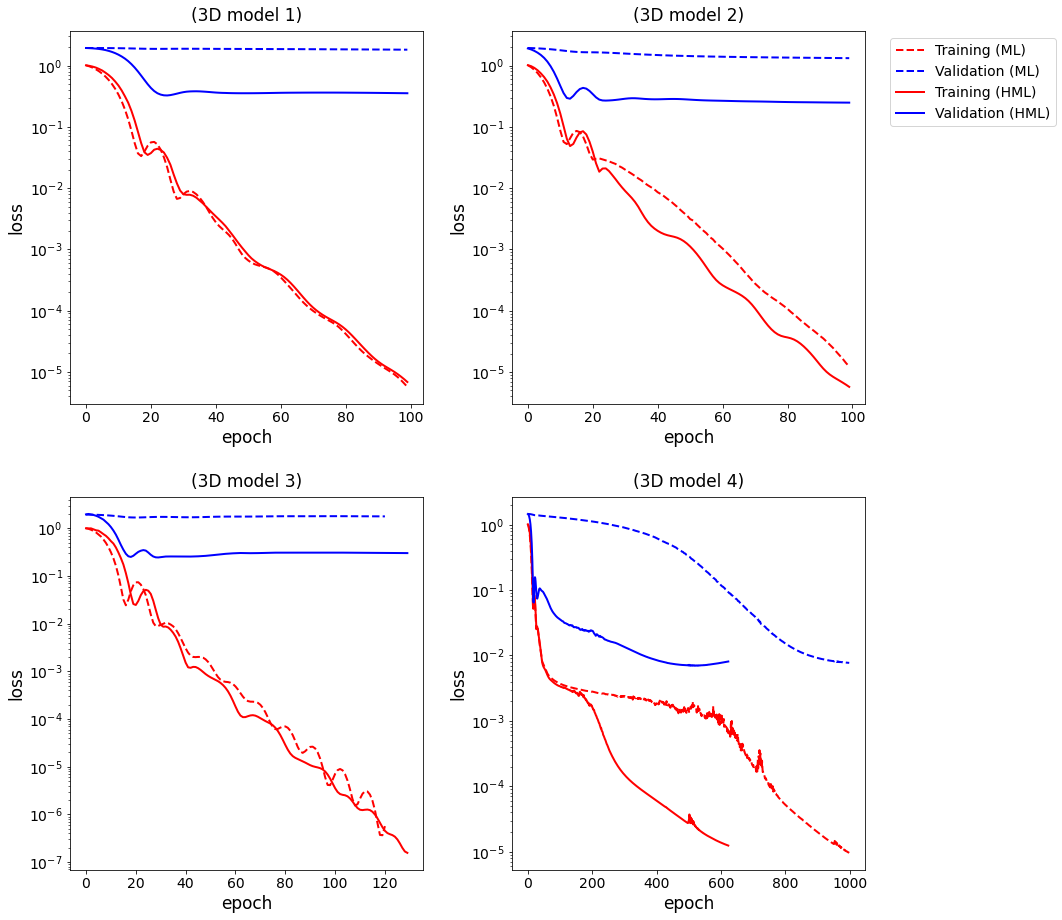

In [3]:
# Plotting the loss funtions:

with open('data_3d', 'rb') as f: result3d = pickle.load(f)

fig, ax = plt.subplots(2,2,figsize=(15,13))
lst = []
k = 0
m = 0
n = 0
p = 0
for result in result3d:
    p += 1
    for modelType in list(result.keys()):
        k += 1
        if p == 1:
            m, n = 0, 0
        elif p == 2:
            m, n = 0, 1
        elif p == 3:
            m, n = 1, 0
        elif p == 4:
            m, n = 1, 1
        
        temp = []
        if modelType == 'ML':
            style = '--'
        else:
            style = '-'
        ax[m,n].plot(result[modelType]['loss'], 'r' + style, linewidth=2)
        ax[m,n].plot(result[modelType]['val_loss'], 'b' + style, linewidth=2)
    
    ax[m,n].set_ylabel('loss')
    ax[m,n].set_xlabel('epoch')
    ax[m,n].set_yscale('log')
    
    if m == 0 and n == 1:
        ax[m,n].legend(['Training (ML)','Validation (ML)','Training (HML)','Validation (HML)'], bbox_to_anchor= (1.05,1))
    
    ax[m,n].set_title('(3D model %s)'%(p), pad=10)

fig.tight_layout()
fig.subplots_adjust(wspace=0.25 , hspace=0.25)
fig.savefig('3d.pdf', format='pdf', dpi=500)

In [4]:
pd.set_option('display.float_format', lambda x: '%.7f' % x)

table = dict()

a = (result3d[0]['ML']['loss'][-1], result3d[1]['ML']['loss'][-1], result3d[2]['ML']['loss'][-1] , result3d[3]['ML']['loss'][-1])
b = (result3d[0]['HML']['loss'][-1], result3d[1]['HML']['loss'][-1], result3d[2]['HML']['loss'][-1] , result3d[3]['HML']['loss'][-1])
c = (result3d[0]['ML']['val_loss'][-1], result3d[1]['ML']['val_loss'][-1], result3d[2]['ML']['val_loss'][-1] , result3d[3]['ML']['val_loss'][-1])
d = (result3d[0]['HML']['val_loss'][-1], result3d[1]['HML']['val_loss'][-1], result3d[2]['HML']['val_loss'][-1] , result3d[3]['HML']['val_loss'][-1])

columns = ['3D model 1' , '3D model 2', '3D model 3' , '3D model 4']
index=['Training (ML)', 'Training (HML)', 'Validation (ML)', 'Validation (HML)']
# Create DataFrame object from a list of tuples
df = pd.DataFrame([a, b, c, d], columns = columns, index=index)

print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  3D model 1 &  3D model 2 &  3D model 3 &  3D model 4 \\
\midrule
Training (ML)    &   0.0000057 &   0.0000123 &   0.0000006 &   0.0000096 \\
Training (HML)   &   0.0000068 &   0.0000057 &   0.0000002 &   0.0000125 \\
Validation (ML)  &   1.8169936 &   1.3181295 &   1.7773948 &   0.0076983 \\
Validation (HML) &   0.3536258 &   0.2480008 &   0.3019600 &   0.0080819 \\
\bottomrule
\end{tabular}



#### PMSE Visualization

In [5]:
def abaqus(data, num_outputs = 1, header = ['S11', 'S22', 'S33'], title = 'First testing sample', script = 'Visualization.py'):
    '''A helper function to call visualization.py file and update its values,
    to save each contour plot.'''
    path = 'temp_' + title.replace(' ', '_')
    data = data.reshape(-1,num_outputs)
    data = data[:,:len(header)]
    np.savetxt(path, X = data, delimiter=",")
    
    # Update visualization.py to correct the address of the image file:
    txt = []
    with open(script, 'r') as f:
        txt = f.readlines()
        idx = txt.index('# START OF AUTOMATICALLY GENERATED PYTHON CODE\n')
        txt[idx + 1] = 'path = "%s"\n'%(path)
    
    with open(script, 'w') as f: f.writelines(txt)
    
    # Run abaqus
    parentFolder = 'C:\\temp\\HybridMl\\'
    os.system('abaqus cae noGUI=' + parentFolder + 'visualization.py');
    
    lst = [i for i in os.listdir() if path == i[:len(path)] and 'png'== i[-3:]]
    img = [mpimg.imread(i)[150:-150, 200:-200, :] for i in lst]
    
    return img

In [6]:
# Extracting contour plots' data for all surrogates.

data = [result3d[0]['ML']['pmse'],
        result3d[0]['HML']['pmse'],
        result3d[1]['ML']['pmse'],
        result3d[1]['HML']['pmse'],
        result3d[2]['ML']['pmse'],
        result3d[2]['HML']['pmse'],
        result3d[3]['ML']['pmse'],
        result3d[3]['HML']['pmse']]

col = header = ['ML', 'HML']
row = ['3D model 1', '3D model 2', '3D model 3', '3D model 4']

img = []
for d in data:
    img.append(abaqus(d, header = header, title = 'temp'))

<Figure size 432x288 with 0 Axes>

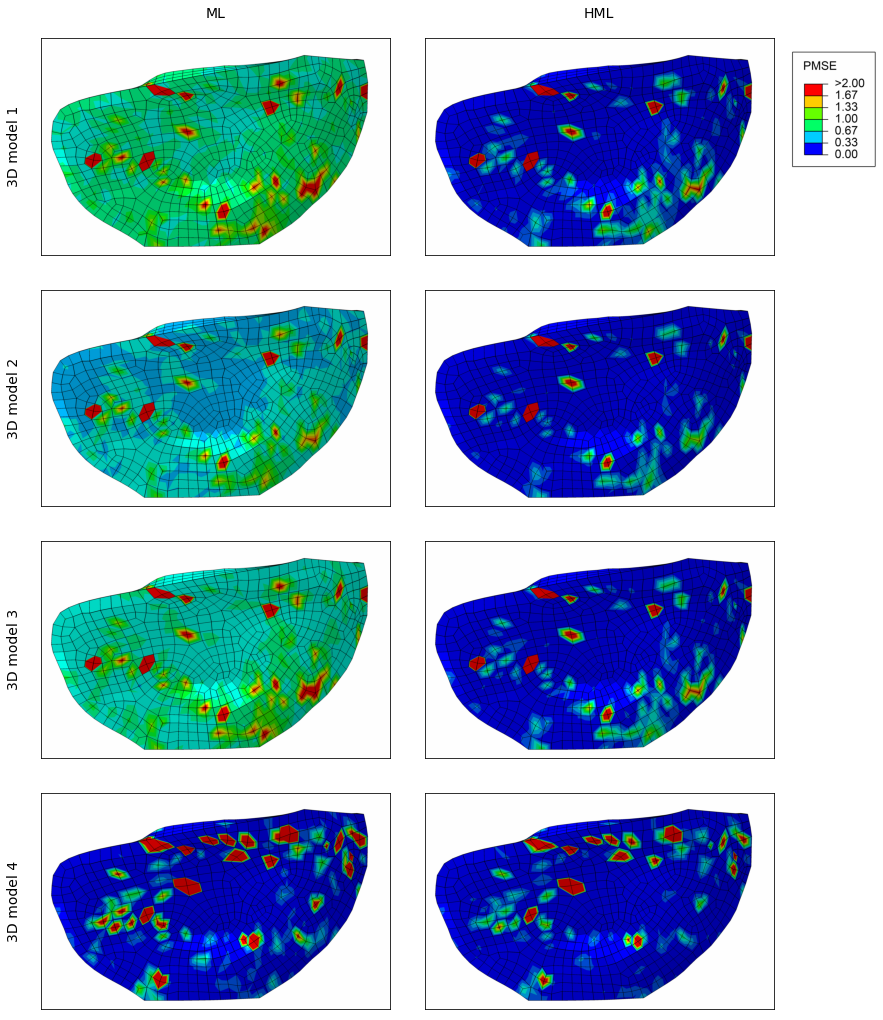

In [9]:
# Visualizing the contour plots.

plt.clf();

fig = plt.figure(figsize=(20, 23))

columns = len(col)+1
rows = len(row)+1

ax = []
for i , image in zip(range(columns*rows), img):

    ax.append(fig.add_subplot(rows, columns, (i+1+((i)//(columns-1)))))
    ax[-1].set_xticks([])
    ax[-1].set_yticks([])
    
    if i in [0 ,1]:
        ax[-1].set_title(col[i], size=14, pad=20)
        ax[-1].title.set_position([.5, 1.1])
    
    if i % 2 == 0:
        ax[-1].set_ylabel(row[i//(columns-1)], rotation=90, size=14)
        ax[-1].yaxis.labelpad = 20
    
    plt.imshow(image[0])

# Adding the PMSE legend (previously generated by Abaqus):
ax.append(fig.add_subplot(8, 12, 9))
ax[-1].axis('off')
ax[-1].set_xticks([])
ax[-1].set_yticks([])
plt.imshow(mpimg.imread("pmse_legend.png"))

fig.subplots_adjust(wspace=0.1 , hspace=0.03)
fig.savefig('visualization_3d.png', format='png', dpi=300)
plt.show()